### Preliminaries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
mpl.rcParams.update(mpl.rcParamsDefault)
from matplotlib import rc
font = {'size'   : 18}
rc('font', **font)

In [3]:
# data is from reference 1
data = pd.read_csv('../data/Table2_Hunt_2013_edit.csv')

### Confidence Interval for the mean response to a particular x 
This Confidence Interval answers the question: "what would the mean value of the target variable y be, in the population, for a particular value of X?" (__Note that this confidence is pointwise in the sense that they consider observations separately__). 
For a worked example see [Brown's Confidence Interval for Mean Response to a Particular x](https://brownmath.com/stat/infregr.htm#MeanResp).

If you like Seaborn aesthetic, and are happy to just plot this Confidence Interval, you get it for free [with __`seaborn.regplot`__](https://seaborn.pydata.org/generated/seaborn.regplot.html). 

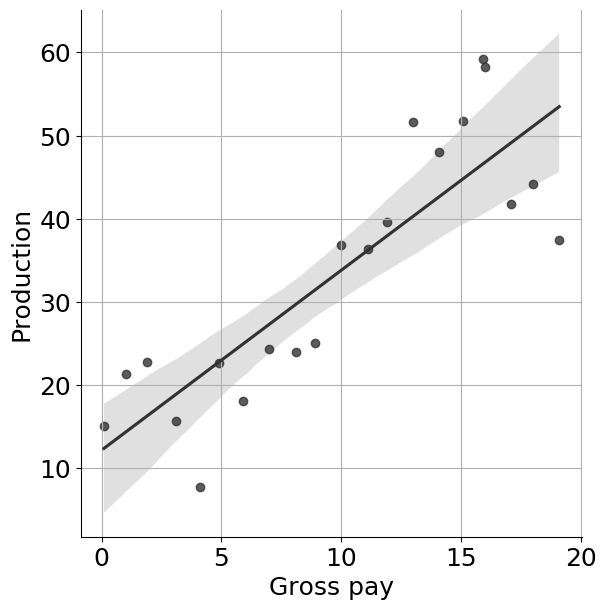

In [4]:
g = sns.PairGrid(data, y_vars=["Production"], x_vars=["Gross pay"], height=6)
g.map(sns.regplot, color="0.2")
plt.grid()
plt.show()

However, there's also a Prediction Interval for responses to a particular x. I find this more interesting and of practical use, as I have highlighted in [Geoscience_ML_notebook 3](https://github.com/mycarta/predict/blob/master/Geoscience_ML_notebook_3.ipynb), where I show how to use it to assess drilling economic risk.

In putting that notebook together, I have benefitted from working through the examples (and the explanation of the difference between Confidence Interval and Prediction Interval) in both [Brown's Prediction Interval for Responses to a Particular x](https://brownmath.com/stat/infregr.htm#IndivResp) and in [this great answer on Cross Validated](https://stats.stackexchange.com/a/271232/54871).

Because I want access to the Prediction Interval (and the Confidence Interval, and the Regression equation), I almost invariably end up not using Seaborn for this sort of work. 

As an aside, this is a very fiercely debated issue (see for example [Display regression equation in seaborn regplot](https://stackoverflow.com/questions/33490833/display-regression-equation-in-seaborn-regplot) and [How to get the numerical fitting results when plotting a regression in seaborn?](https://stackoverflow.com/questions/22852244/how-to-get-the-numerical-fitting-results-when-plotting-a-regression-in-seaborn/22852265) on Stack Overflow). As a user I have at times been frustrated by not being able to access the Seaborn regression coefficients and statistics, but ultimately I agree with the developer that this is [not in the scope of Seaborn](https://stackoverflow.com/a/47062135/1034648) and that we may be better off putting in the hard work [which was perfectly captured in this comment](https://stackoverflow.com/questions/33490833/display-regression-equation-in-seaborn-regplot#comment99816004_47062135)

### Statsmodels' Ordinary Least Square regression Gross-Pay > Production

#### Case 1 - using all wells

In [5]:
data_for_OLS = data.drop(['Random 1','Random 2','Gross pay transform', 'Position','Pressure', 'Phi-h'], axis=1)
#data_for_OLS

In [6]:
indexed_data = data_for_OLS.set_index([np.arange(1,22,1)])
sort_data = indexed_data.sort_values(by='Gross pay', ascending=True)
X = sort_data.loc[:,['Gross pay']]
X = sm.add_constant(X, prepend=False) # add intercept
y = sort_data.loc[:,'Production']

In [7]:
# uncomment below to take a peak at the regression results first
#model = sm.OLS(y, X)
#results = model.fit()

# uncomment below to print the OLS regression results summary
#print(results.summary())

# uncomment below to print the regression coefficients
#print(results.params) 

#### Accessing results and plotting

In [8]:
def plot_CI_PI(X, y, alpha = 0.05, CI=True, PI = True, idx = False, savefig = False):
    """ This function performs OLS regression, then plots:
    - The X,y data points
    - The regression line and its equation
    - The Confidence Interval region
    - The Prediction Interval band
    - Confidence Interval for a selected point
    - Prediction Interval for a selected point
    """
    
    # preparing variables
    Xc = sm.add_constant(X, prepend=False) # add intercept
    model = sm.OLS(y, Xc)
    results = model.fit()
    pred = results.get_prediction()
    pred_df = pred.summary_frame(alpha=alpha)
    mean   =  pred_df['mean']
    pi_low = pred_df['obs_ci_lower'] 
    pi_upp = pred_df['obs_ci_upper']
    ci_low = pred_df['mean_ci_lower'] 
    ci_upp = pred_df['mean_ci_upper']

    # set up plot
    plt.figure(figsize=(12, 12))
    
    # plot data points
    plt.plot(X, y, 'o', label = 'Data: ' + str(len(y)) + ' wells')
    # plot regression line
    plt.plot(X, mean, '-', lw=2, 
             label = 'OLS: y = {:.3f}'.format(results.params[0]) +  '*x + '  + '{:.2f}'.format(results.params[1]))
    
    # plotting CI and PI
    if CI:
        plt.fill_between(X, pi_low, pi_upp, alpha=0.2, label = 'Prediction Interval band')
    if PI:
        plt.fill_between(X, ci_low, ci_upp, alpha=0.2, label = 'Confidence Interval region')

    # plotting individual x point and its CI and PI
    if idx:
        plt.scatter (X[idx], y[idx], s=120, facecolors = 'k', alpha = 0.4, zorder = 10)
        if PI:
            plt.vlines(X[idx], ymin=pi_low[idx], ymax=pi_upp[idx], colors='darkblue', linestyles='dashed', linewidth=2,  label = 'PI for selected point')
        if CI:
            plt.vlines(X[idx], ymin=ci_low[idx], ymax=ci_upp[idx], colors='maroon', linewidth= 4,  label = 'CI for selected point')

    #final touches
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.ylim([np.amin(pi_low), np.amax(pi_upp)])
    plt.xlim([0, np.amax(X)])
    plt.legend(loc=2)
    plt.grid(b=True, which='major', color='k', linewidth=0.2)
    
    # save to png file if required

    if savefig:
        nwells = len(y)
        filename = 'plot_CI_PI_' + str(nwells) + '.png'
        plt.savefig(filename, dpi=400, bbox_inches='tight', pad_inches=0.1)

    plt.show();

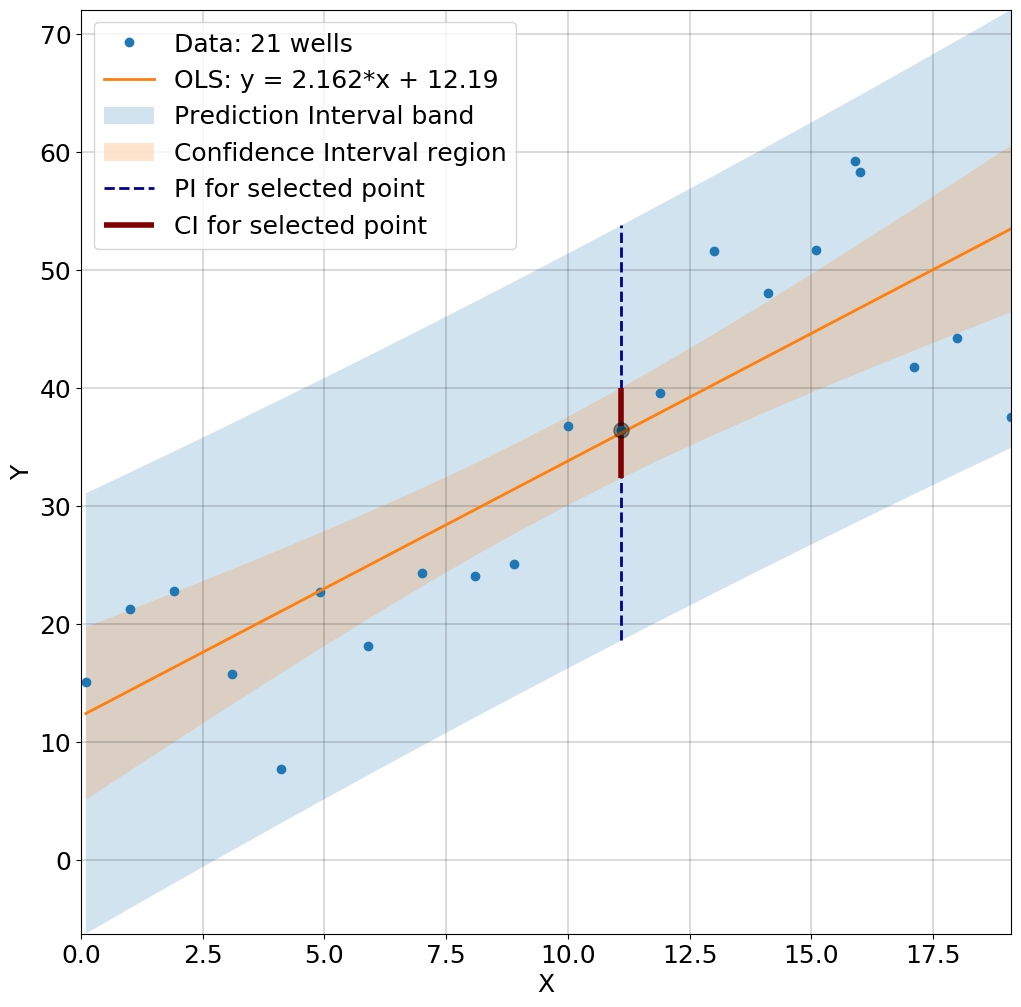

In [9]:
plot_CI_PI(sort_data['Gross pay'], y, CI=True, PI = True, idx = 12, savefig = True)

### Statsmodels' Ordinary Least Square regression Gross-Pay > Production

#### Case 2 - using a subset of 5 wells

In [10]:
data_for_OLS = data.loc[[0,4,8,15,20],['Gross pay','Production']]
data_for_OLS

,Gross pay,Production
0,0.1,15.10
4,4.1,7.71
8,8.1,24.04
15,15.1,51.72
20,19.1,37.51


In [11]:
indexed_data = data_for_OLS.set_index([np.arange(1,6,1)])
sort_data = indexed_data.sort_values(by='Gross pay', ascending=True)
X = sort_data.loc[:,['Gross pay']]
X = sm.add_constant(X, prepend=False) # add intercept
y = sort_data.loc[:,'Production']

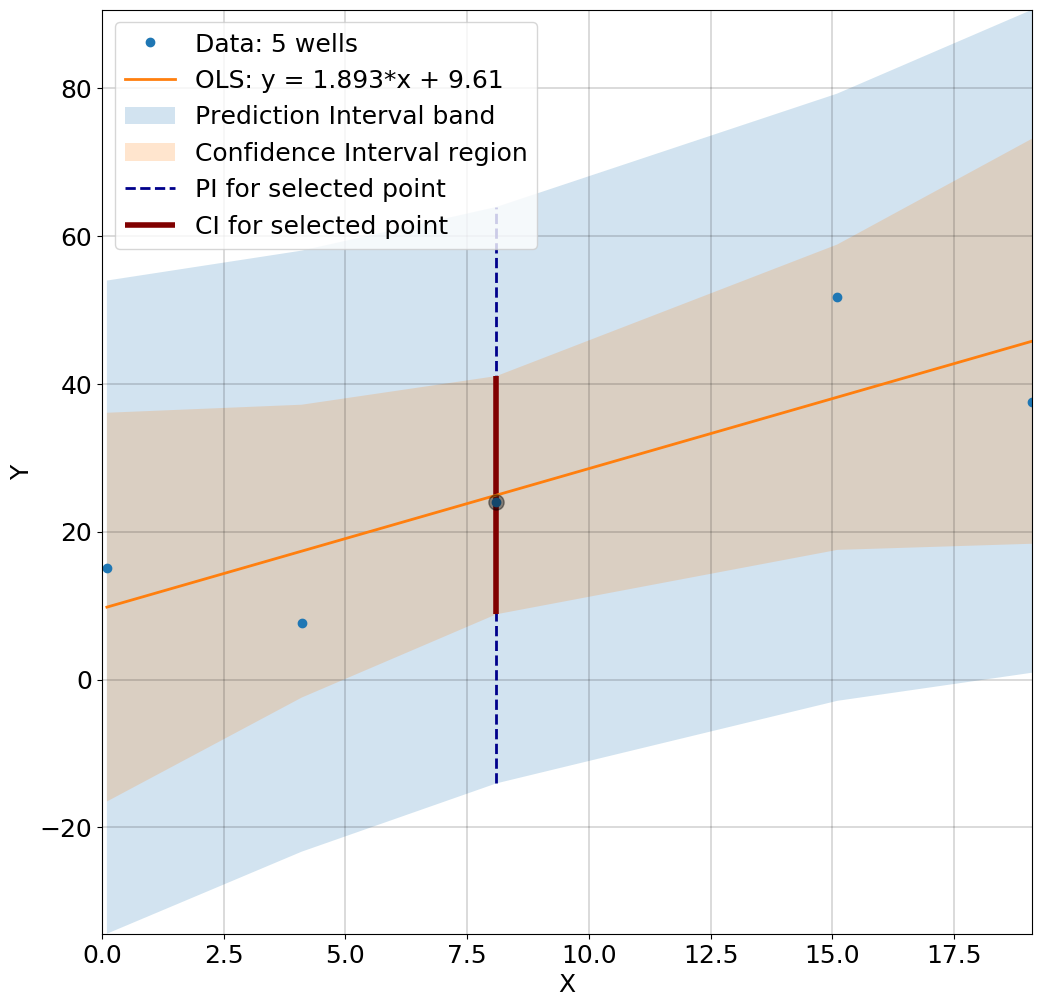

In [12]:
plot_CI_PI(sort_data['Gross pay'], y, CI=True, PI = True, idx = 3, savefig = True)

__Both Confidence Interval and Prediction interval are much larger!__

## References

1) [Many correlation coefficients, null hypoteses, and high value](http://csegrecorder.com/features/view/value-of-integrated-geophysics-201312), Lee Hunt, CSEG Recorder, December 2013.

2) [Stats without tears](https://brownmath.com/swt/), free online text by Stan Brown.

3) [Quantitative use of seismic attributes for reservoir characterization](http://csegrecorder.com/articles/view/too-many-seismic-attributes) Richard Chambers and Jeffrey Yarus, CSEG Recorder, June 2002.

4) [Regression Statistics with Python](https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics).